# Homework 32 (Late)
Section 6.7

Logan Schelly

Fall 2019

Math 402

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt

## Exercise 6.31
Run a multiclass (softmax) logistic regression on the scikit-learn digits dataset with a 30-70 test-train split.

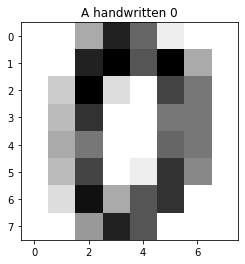

In [2]:
#Load the digits dataset.
dataset = load_digits()
X = dataset['data']
y = dataset['target']

#Plot the first one to see if it makes sense.
plt.imshow(X[0].reshape((8,8)), cmap='gray_r')
plt.title("A handwritten {}".format(y[0]))
plt.show()

In [3]:
#Make a test-train split
from sklearn.model_selection import train_test_split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.30, train_size = 0.70
)

#Make a classifier
dclf = LogisticRegression(solver='saga', multi_class='multinomial')
dclf.fit(X_train, y_train)
dclf.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.95

In [5]:
#Look at the confusion matrix.
from sklearn.metrics import confusion_matrix
y_predict = dclf.predict(X_test)
cm = confusion_matrix(y_test, y_predict)
cm

array([[38,  0,  0,  0,  1,  1,  0,  0,  0,  0],
       [ 0, 53,  0,  0,  1,  0,  0,  0,  1,  0],
       [ 0,  0, 56,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 66,  0,  1,  0,  0,  1,  0],
       [ 0,  1,  0,  0, 47,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 55,  0,  1,  0,  1],
       [ 0,  4,  0,  0,  2,  0, 51,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 44,  0,  1],
       [ 1,  4,  0,  1,  0,  1,  0,  0, 48,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  3, 55]], dtype=int64)

In [6]:
#Make sure the counts match up.
cm.sum() - y_test.size

0

### Exercise 6.31 Continued

Experiment with different regularization parameters and choose the best.  Justify your choice.

##### What are the regularization parameters?

From reading scikit-learn's
[API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) 
and [user guide](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression),
if we set the parameter ``penalty`` equal to ``'elasticnet'``, we will be using this cost function:
$$
\frac{1 - \rho}{2} \boldsymbol{\beta}^T\boldsymbol{\beta}
+ \rho \Vert \boldsymbol{\beta} \Vert_1
+ C \sum_{i=1}^{n}\log\left( 
        \exp\left(
        -y_i (X_i^T \boldsymbol{\beta} +\beta_{const})
        \right)
        + 1
    \right)
$$
In this case, $\rho$ (specified as ``l1_ratio``) controls how much $\ell_1$ and $\ell_2$ norms contribute, and $C$ controls how strongly regularization affects things.

If we set ``multi_class`` to ``multinomial``, I assume that we're using the corresponding objective function for multinomial logistic regression.
Checking the [source code](https://github.com/scikit-learn/scikit-learn/blob/e5698bde9/sklearn/linear_model/_logistic.py#L250)
for the $\ell_2$ regularized cost function, it seems like we are.
However, I don't know this for sure, because elastic net regularization requires that you specify ``solver`` as ``saga``, and you have to go very deep down the rabbit hole to find what the cost function is.  I stopped digging once I'd followed references across 2 subpackages and the source code was no longer in python.

##### Which way will I choose regularization parameters?
Since the cost function for multinomial regression includes the multiclass cross-entropy loss function, that's the function I will use to score parameter choices.  Scikit-learn specifies this with ``'neg_log_loss'``.

##### How do I justify that?
It just seems to make sense to use the same function for both building and evaluating the model.  Obviously, there's some overfitting problems that might arise, but that's why you add regularization terms to the model-building function and don't include them in the model-evaluating function.

Using MLE to build the model, and then evaluating it with missclassification rate, or AIC just seems like you're working against yourself.  You're not building the model to fit the objective you have in mind.

In [7]:
#Since we're experiementing with different regularization parameters,
#It seems best to just use a GridSearchCV
from sklearn.model_selection import GridSearchCV

In [13]:
#Reinitialize the logistic digit classifier
dclf = LogisticRegression(solver='saga', multi_class='multinomial', penalty='elasticnet')

#Set up the grid
rhos = np.linspace(0, 1, 5) #Ratio of l1 weight vs l2
Cs = 2.0**np.arange(-2, 3, 1) #How much the loss is weighted.
param_grid = {'C':Cs, 'l1_ratio':rhos}

#Do the search.
my_gs = GridSearchCV(dclf, param_grid, cv=5, scoring='neg_log_loss',
                    n_jobs=4, verbose=1)
my_gs.fit(X_train, y_train)

Fitting 7 folds for each of 25 candidates, totalling 175 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done 175 out of 175 | elapsed:   39.9s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=7, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100,
                                          multi_class='multinomial',
                                          n_jobs=None, penalty='elasticnet',
                                          random_state=None, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=4,
             param_grid={'C': array([0.25, 0.5 , 1.  , 2.  , 4.  ]),
                         'l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=1)

In [15]:
print("Best parameters:", my_gs.best_params_)
print("Best score:", my_gs.best_score_)

Best parameters: {'C': 0.25, 'l1_ratio': 0.0}
Best score: -0.09787186471452396


In [17]:
dclf = LogisticRegression(solver='saga', multi_class='multinomial', penalty='elasticnet',
                         C=0.25, l1_ratio=0.0)
dclf.fit(X_train, y_train)
dclf.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.95